In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


# Code

In [2]:
#export
from functools import reduce

from typing import Union

from scipy import sparse
import numpy as np

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline

from joblib import effective_n_jobs, Parallel, delayed

from sknetwork.clustering import KMeans, Louvain, PropagationClustering

from utils import hstack, sparse_dot_product

import pandas as pd

In [3]:
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

## Data Gneration

In [4]:
#session of variables to testing sessions
n_features = 7
cardinality_per_feature = 1000
n_classes = 5
n_reg_dims = 2


X = np.random.randint(0,cardinality_per_feature,(1000,n_features))

y_class = np.random.randint(0,n_classes, 1000)
y_reg = np.random.randn(1000,n_reg_dims)

In [5]:
#export
from sklearn.datasets import make_regression

def sigmoid(x):
    return 1/(1+np.exp(x))

def make_bimodal_assymetric_regression(
    n_samples=100000,
    bimodal_factor_weight = 2,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=10,
    noise=150,
    shuffle=True,
    coef=False,
    random_state=None
):
    
    X,y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_targets=n_targets,
        bias=bias,
        effective_rank=effective_rank,
        tail_strength=tail_strength,
        noise=noise,
        shuffle=shuffle,
        coef=coef,
        random_state=random_state
    )


    #make one of X[1] feature mode weightening    
    bimodal_factors = (sigmoid(bimodal_factor_weight*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
    bimodal_factors[bimodal_factors == 0] = -1
    bimodal_factors = bimodal_factors.reshape(-1,1)

    y = bimodal_factors*y
    
    return X,y

In [201]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, make_blobs
import seaborn as sns

%matplotlib inline

X_clf, y_clf = make_classification(
    n_samples = 10_000,
    n_features = 16,
    n_informative = 8,
    n_redundant = 0,
    #bias = 10,
    #noise = 10,
    n_classes = 6,
    n_clusters_per_class = 2,
    hypercube = True,
)


blobs, labels = make_blobs(n_samples = 10_000,cluster_std = 3, n_features = 4)
#sns.scatterplot(*blobs.T, hue = labels)
#plt.show()

In [202]:
from sklearn.model_selection import train_test_split

In [203]:
from lightgbm import LGBMClassifier,LGBMRegressor,LGBMRanker


In [204]:
clf = LGBMClassifier().fit(X,y)

In [205]:
#sns.jointplot(data = model_df, x = "count", y = "unit_parent_gain")

In [ ]:
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
model_df["count"]/model_df["parent_count"]

In [ ]:



model_df = clf.booster_.trees_to_dataframe()
leafs = clf.predict(X, pred_leaf = True)

d_cols = ["split_gain","parent_index","node_index","count"]
parent_split_gain = pd.merge(model_df[d_cols], model_df[d_cols], left_on = "parent_index", right_on = "node_index", how = "left")

root_nodes = model_df[model_df["parent_index"].isna()][["tree_index","node_index"]].rename(columns={"node_index":"root_node"})
model_df = model_df.merge(root_nodes, how = "left", on = "tree_index")

model_df["parent_gain"] = parent_split_gain["split_gain_y"]
model_df["parent_count"] = parent_split_gain["count_y"]
model_df["parent_fraction"] = model_df["count"]/model_df["parent_count"]
model_df["cumulative_gain"] = model_df["parent_gain"]*model_df["parent_fraction"]

model_df["unit_parent_gain"] = model_df["parent_gain"]/model_df["count"]
model_df["unit_parent_gain"] = model_df["unit_parent_gain"].fillna(0)

#model_df["unit_gain"] = model_df["split_gain"]/model_df["count"]
model_df["inverse_count"] = 1/model_df["count"]
model_df["unit_weight"] = model_df["weight"]/model_df["count"]

model_df["leaf_index"] = model_df["node_index"].str.split("-").str[1].str[1:].astype(int)
model_df["leaf_index"] = np.where(model_df["right_child"].isna(), model_df["leaf_index"], None)

#path_indpr = np.hstack([[0], model_df.reset_index().groupby("tree_index")["index"].max().values])
leaf_indexes = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"]).index.values
leaf_index_map = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"])["node_index"]
path_pairs_df = model_df.dropna(subset = ["leaf_index"])[["root_node","node_index"]]



g = nx.Graph()
g.add_nodes_from(model_df["node_index"])
#if weighted:    
#    edge_weight_column = "parent_gain"
#    z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index",edge_weight_column]].dropna().values))
#    g.add_weighted_edges_from(z)

z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index"]].dropna().values))
g.add_edges_from(z)
    
    
leafs = clf.predict(X, pred_leaf = True)
leaf_encoder = OneHotEncoder().fit(leafs)

#encoded = leaf_encoder.transform(leafs)
    
#terminal_nodes = np.array(np.split(encoded.nonzero()[1], leafs.shape[0]))

In [ ]:
#check leaf nodes orderning according to output leaf nodes of estimator
(model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"])["count"].values == OneHotEncoder().fit_transform(leafs).sum(0).A.flatten()).mean()

In [ ]:
from tqdm import tqdm
node_weight = "cumulative_gain"
path_pairs = list(tuple(i) for i in tuple(path_pairs_df.values))
paths = np.array([np.array(nx.shortest_path(g, *i)) for i in path_pairs])

weights_df = model_df.set_index("node_index")[[node_weight, "tree_index", "node_depth"]]
weights_df["network_weight"] = np.nan
for i in (np.arange(len(path_pairs_df["node_index"]))):
    weights_df.loc[path_pairs_df.loc[path_pairs_df.index[i],"node_index"], "network_weight"] = weights_df.loc[paths[i], node_weight].sum()
    

In [ ]:
leaf_weights = weights_df.loc[leaf_index_map, "network_weight"].values.reshape(1,-1)
weights_df.groupby("tree_index").mean()[[node_weight, "network_weight"]].plot()

# Archetypoe embedder

In [85]:
from hml.ensemble import LGBMClassificationTransformer, GraphArchetypeEncoder

In [206]:
#X = data["data"]
#y = KBinsDiscretizer(n_bins = 10, encode = "ordinal").fit_transform(data["target"].reshape(-1,1)).flatten()

X, X_test, y, y_test = train_test_split(X_clf,y_clf, test_size = 0.90)

In [87]:
clf = LGBMClassificationTransformer().fit(X, y, leaf_weights_strategy="cumulative_unit_gain")


In [90]:
embeder = GraphArchetypeEncoder(clf, 10, prefit_ensemble=True, use_leaf_weights=True, fuzzy_membership=False, n_jobs = -1, graph_cluster_method = "kmeans", beta = 1)
embeder.fit(X,y)

GraphArchetypeEncoder(ensemble_estimator=LGBMClassificationTransformer(),
                      n_archetypes=10, n_jobs=-1, prefit_ensemble=True,
                      use_leaf_weights=True)

In [ ]:
archetypes = embeder.transform(X)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
logreg = LGBMClassifier()
logreg.fit(archetypes, y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
archetypes_test = embeder.transform(X_test, alpha = 1)

In [ ]:
preds = logreg.predict_proba(archetypes_test)
preds_gbm = embeder.ensemble_estimator.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test, preds, multi_class="ovr"), roc_auc_score(y_test, preds_gbm, multi_class="ovr")

# Archetype estimator

In [91]:
from hml.meta_estimators import ArchetypeEnsembleClassifier
# X = data["data"]
# y = KBinsDiscretizer(n_bins = 10, encode = "ordinal").fit_transform(data["target"].reshape(-1,1)).flatten()

# X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2)

In [92]:
# clf = LGBMClassifierTransformer(n_estimators=100).fit(X, y, leaf_weights_strategy="cumulative_unit_gain")
# embeder = ArchetypeEncoder(clf, 10, prefit_ensemble=True, use_leaf_weights=True, fuzzy_membership=True, n_jobs = -1, graph_cluster_method = "kmeans", beta = 1, alpha =1)
# embeder.fit(X,y)

In [93]:
from sklearn.preprocessing import QuantileTransformer

final_estim = LGBMClassifier(n_estimators=100)
estim = ArchetypeEnsembleClassifier(embeder, final_estim, prefit_embedder=True,)

In [94]:
import warnings
warnings.filterwarnings("ignore")
estim.fit(X,y)

ArchetypeEnsembleClassifier(base_embedder=GraphArchetypeEncoder(ensemble_estimator=LGBMClassificationTransformer(),
                                                                n_archetypes=10,
                                                                n_jobs=-1,
                                                                prefit_ensemble=True,
                                                                use_leaf_weights=True),
                            final_transformer=LGBMClassifier(),
                            prefit_embedder=True)

In [95]:
preds = estim.predict_proba(X_test)
preds_gbm = estim.base_embedder_.ensemble_estimator.predict_proba(X_test)

In [96]:
roc_auc_score(y_test, preds, multi_class="ovr"), roc_auc_score(y_test, preds_gbm, multi_class="ovr")

(0.9701756343625513, 0.9644591173189592)

# TargetBased Archetype encoder

In [279]:
from sklearn.datasets import fetch_california_housing
from hml.ensemble import TargetArchetypeEncoder
from hml.meta_estimators import ArchetypeEnsembleClassifier

data_house = fetch_california_housing()
X_house = data_house["data"]
y_house = KBinsDiscretizer(n_bins = 10, encode = "ordinal").fit_transform(data_house["target"].reshape(-1,1)).flatten()

X_house, X_house_test, y_house, y_house_test = train_test_split(X_house,y_house, test_size = 0.2)

In [280]:
from sklearn.cluster import KMeans
from sklearn.ensemble import StackingClassifier
from sklearn.compose import ColumnTransformer

In [281]:
class CustomColumnTransformer(ColumnTransformer):
    def fit(self, X, y=None, sample_weight=None, **kwargs):
        return super().fit(X,y)

In [511]:
from hml.ensemble import ClusterArchetypeEncoder, GraphArchetypeEncoder, TargetArchetypeEncoder, _ForestTransformer

In [323]:
from sklearn.base import ClassifierMixin

In [498]:
class CustomArchetypeEnsembleClassifier(ArchetypeEnsembleClassifier, ClassifierMixin):
    pass

from sklearn.random_projection import GaussianRandomProjection
from sklearn.cluster import KMeans
from sklearn.preprocessing import FunctionTransformer, normalize

In [505]:
from sklearn.pipeline import Pipeline
class CustomPipeline(Pipeline):
    def fit(self, X, y=None, **kwargs):
        return super().fit(X,y)

In [617]:
from hml.ensemble import ClusterArchetypeEncoder

In [628]:
from sklearn.preprocessing import QuantileTransformer
from hml.preprocessing import RobustKBinsDiscretizer
#final_estim = LGBMClassifier(n_estimators=100, n_jobs = -1)
#final_estim = make_pipeline(RobustKBinsDiscretizer(n_bins = 10, fuzzy_alpha=0), LogisticRegression())
final_estim = RandomForestClassifier(20,n_jobs= -1, min_samples_leaf = 2)

#partition_estim = LGBMClassifier(n_estimators=100, n_jobs = -1)
partition_estim = (RandomForestClassifier(20, n_jobs= -1, min_samples_leaf = 2))
#partition_estim = make_pipeline(RobustKBinsDiscretizer(n_bins = 5, fuzzy_alpha=1), LogisticRegression())
#partition_estim = ExtraTreesClassifier(n_jobs=-1)
#partition_estim = LGBMClassificationTransformer("rf", bagging_fraction = 0.99, bagging_freq = 1, min_child_samples=2)
#partition_estim = RandomTreesEmbedding()
stacked = StackingClassifier([("estim",clone(final_estim))], clone(final_estim), passthrough = True, stack_method = "predict_proba", cv = 2)

tgt_enc = TargetArchetypeEncoder(partition_estim, n_archetypes=10)
cls_enc = ClusterArchetypeEncoder(partition_estim, clusterer=KMeans(10))
grp_enc = GraphArchetypeEncoder(partition_estim, n_archetypes=10)


svd_enc = Pipeline([
    ("ensemble_transformer",_ForestTransformer(partition_estim)),
    ("dim_reduce",GaussianRandomProjection(10)),
    ("clusterer",KMeans(10)),
    ("normalizer",FunctionTransformer(lambda x: sparse.csr_matrix(normalize(np.clip(1/x, 0, np.finfo(np.float32).max), "l1"))))
])


grp_enc_pipe = CustomColumnTransformer([
    ("estim",grp_enc,np.arange(X_house.shape[-1])),
    ("pass","passthrough",np.arange(X_house.shape[-1]))
])

cls_enc_pipe = CustomColumnTransformer([
    ("estim",cls_enc,np.arange(X_house.shape[-1])),
    ("pass","passthrough",np.arange(X_house.shape[-1]))
])

tgt_enc_pipe = CustomColumnTransformer([
    ("estim",tgt_enc,np.arange(X_house.shape[-1])),
    ("pass","passthrough",np.arange(X_house.shape[-1]))
])


#enc1 = ArchetypeEncoder(partition_estim, n_archetypes=10, prefit_estimator=False)
ensemble1 = clone(stacked)#StackingClassifier([("estim",clone(final_estim))], clone(final_estim), passthrough = True, stack_method = "predict_proba", cv = 2)

ensemble2 = ArchetypeEnsembleClassifier(cls_enc, clone(final_estim))
#enc2 = TargetArchetypeEncoder(ensemble1, n_archetypes=20, prefit_estimator=False)
#ensemble1 = ArchetypeEnsembleClassifier(enc2, final_estim, prefit_embedder=False,)
ensemble3 = ArchetypeEnsembleClassifier(cls_enc, clone(stacked))

[autoreload of ensemble failed: Traceback (most recent call last):
  File "/Users/alan.ganem/miniconda3/envs/hml/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/alan.ganem/miniconda3/envs/hml/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/alan.ganem/miniconda3/envs/hml/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/alan.ganem/dev/personal/heterogeneous-metric-learning/hml/ensemble.py", line 28, in <module>
    from .utils import hstack, sparse_dot_product
ImportError: attempted relative import with no known parent package
]


In [629]:
final_estim.fit(X_house,y_house)
partition_estim.fit(X_house,y_house)

RandomForestClassifier(min_samples_leaf=2, n_estimators=20, n_jobs=-1)

In [630]:
ensemble1.fit(X_house,y_house)

StackingClassifier(cv=2,
                   estimators=[('estim',
                                RandomForestClassifier(min_samples_leaf=2,
                                                       n_estimators=20,
                                                       n_jobs=-1))],
                   final_estimator=RandomForestClassifier(min_samples_leaf=2,
                                                          n_estimators=20,
                                                          n_jobs=-1),
                   passthrough=True, stack_method='predict_proba')

In [631]:
ensemble2.fit(X_house,y_house)

ArchetypeEnsembleClassifier(base_embedder=GraphArchetypeEncoder(ensemble_estimator=RandomForestClassifier(min_samples_leaf=2,
                                                                                                          n_estimators=20,
                                                                                                          n_jobs=-1),
                                                                n_archetypes=10),
                            final_transformer=StackingClassifier(cv=2,
                                                                 estimators=[('estim',
                                                                              RandomForestClassifier(min_samples_leaf=2,
                                                                                                     n_estimators=20,
                                                                                                     n_jobs=-1))],
                                                                 final_estimator=RandomForestClassifier(min_samples_leaf=2,
                                                                                                        n_estimators=20,
                                                                                                        n_jobs=-1),
                                                                 passthrough=True,
                                                                 stack_method='predict_proba'))

In [ ]:
ensemble3.fit(X_house,y_house)

[autoreload of ensemble failed: Traceback (most recent call last):
  File "/Users/alan.ganem/miniconda3/envs/hml/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/alan.ganem/miniconda3/envs/hml/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/alan.ganem/miniconda3/envs/hml/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/alan.ganem/dev/personal/heterogeneous-metric-learning/hml/ensemble.py", line 28, in <module>
    from .utils import hstack, sparse_dot_product
ImportError: attempted relative import with no known parent package
]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#preds = ensemble1.predict_proba(X_test, alpha = 1, normalization_method = "l1")
preds = ensemble1.predict_proba(X_house)
preds2 = ensemble2.predict_proba(X_house)
preds3 = ensemble3.predict_proba(X_house)
preds_gbm = final_estim.predict_proba(X_house)
#preds_partition = partition_estim.predict_proba(X_house_test)

In [ ]:
(roc_auc_score(y_house, preds, multi_class="ovr") - roc_auc_score(y_house, preds_gbm, multi_class="ovr"))*100

In [ ]:
(roc_auc_score(y_house, preds2, multi_class="ovr") - roc_auc_score(y_house, preds_gbm, multi_class="ovr"))*100

In [ ]:
(roc_auc_score(y_house, preds3, multi_class="ovr") - roc_auc_score(y_house, preds_gbm, multi_class="ovr"))*100

In [ ]:
#preds = ensemble1.predict_proba(X_test, alpha = 1, normalization_method = "l1")
preds = ensemble1.predict_proba(X_house_test)
preds2 = ensemble2.predict_proba(X_house_test)
preds3 = ensemble3.predict_proba(X_house_test)
preds_gbm = final_estim.predict_proba(X_house_test)
#preds_partition = partition_estim.predict_proba(X_house_test)

In [ ]:
(roc_auc_score(y_house_test, preds, multi_class="ovr") - roc_auc_score(y_house_test, preds_gbm, multi_class="ovr"))*100

In [ ]:
roc_auc_score(y_house_test, preds2, multi_class="ovr"), (roc_auc_score(y_house_test, preds2, multi_class="ovr") - roc_auc_score(y_house_test, preds_gbm, multi_class="ovr"))*100

In [ ]:
(roc_auc_score(y_house_test, preds3, multi_class="ovr") - roc_auc_score(y_house_test, preds_gbm, multi_class="ovr"))*100

# Cluster archetyope encoder

In [111]:

from hml.ensemble import LGBMClassificationTransformer, LGBMRankingTransformer, LGBMRegressionTransformer
from lightgbm import LGBMClassifier, LGBMRanker, LGBMRegressor

In [112]:
from sklearn.base import BaseEstimator, clone, TransformerMixin

In [113]:
from sklearn.cluster import MiniBatchKMeans

In [114]:
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import TruncatedSVD

In [115]:
from ensemble import GraphArchetypeEncoder

enc1 = ClusterArchetypeEncoder2(LGBMClassifier(n_jobs = -1), GaussianRandomProjection(100), KMeans(10))
enc2 = ClusterArchetypeEncoder(LGBMClassifier(n_jobs = -1), GaussianRandomProjection(100), KMeans(10))

In [116]:
enc1.fit(X, y)
enc2.fit(X, y)

ClusterArchetypeEncoder(clusterer=KMeans(n_clusters=10),
                        embedder=GaussianRandomProjection(n_components=100),
                        ensemble_estimator=LGBMClassifier())

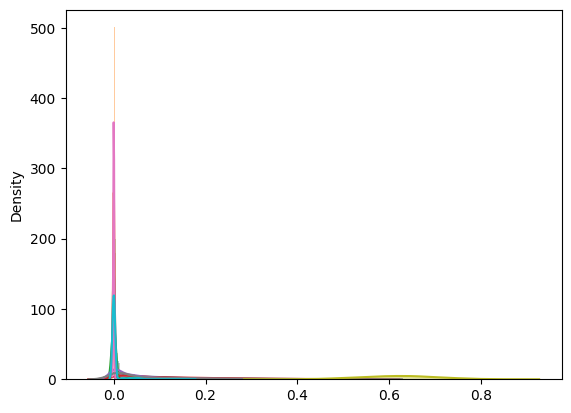

In [117]:
import warnings
warnings.filterwarnings("ignore")

t1 = enc1.transform(X).A
for ti in t1.T:
    sns.distplot(ti.flatten())

In [118]:
(t1==0).mean()

0.54929

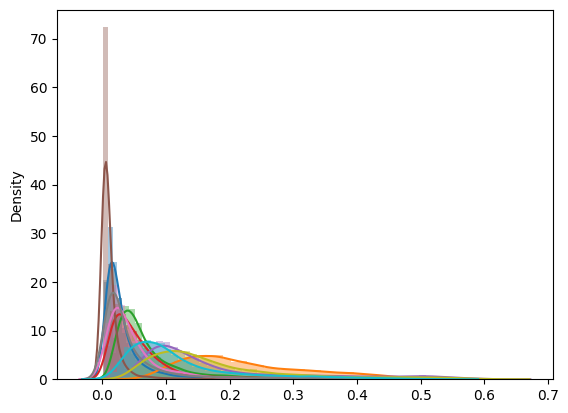

In [119]:
t2 = enc2.transform(X).A
for ti in t2.T:
    sns.distplot(ti.flatten())

In [120]:
(t2==0).mean()

0.0

# FOrest induced UMAP

In [122]:
from hml.ensemble import ClusterArchetypeUMAP, GraphArchetypeUMAP
lgbm_transformer = LGBMClassificationTransformer(n_estimators=30)#.fit(X,y, leaf_weights_strategy = "cumulative_unit_gain")

In [123]:
graph_embedder = make_pipeline(lgbm_transformer, GraphArchetypeUMAP(n_components = 2, n_neighbors = 15,fuzzy_membership=True, metric = "cosine", gamma = 1))
cluster_embedder = make_pipeline(lgbm_transformer, ClusterArchetypeUMAP(n_components = 2, n_neighbors = 15, metric = "cosine", gamma = 1))

graph_embedder.fit(X,y)
cluster_embedder.fit(X,y)


Pipeline(steps=[('lgbmclassificationtransformer',
                 LGBMClassificationTransformer(n_estimators=30)),
                ('clusterarchetypeumap', ClusterArchetypeUMAP())])

In [126]:
graph_embs = graph_embedder.transform(X)
cluster_embs = cluster_embedder.transform(X)

graph_embs_test = graph_embedder.transform(X_test)
cluster_embs_test = cluster_embedder.transform(X_test)

In [127]:
graph_net_embs = graph_embedder[1].network_embeddings_
graph_importances = graph_embedder[1].archetype_importances_

cluster_net_embs = cluster_embedder[1].network_embeddings_
cluster_importances = cluster_embedder[1].archetype_importances_

In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [129]:
graph_knn_preds_test = KNeighborsClassifier(50,metric = "euclidean", n_jobs = -1, weights = "distance").fit(graph_embs,y).predict_proba(graph_embs_test)
cluster_knn_preds_test = KNeighborsClassifier(50, metric = "euclidean", n_jobs = -1, weights = "distance").fit(cluster_embs,y).predict_proba(cluster_embs_test)



In [130]:
roc_auc_score(y_test,graph_knn_preds_test, multi_class="ovr"), roc_auc_score(y_test,cluster_knn_preds_test, multi_class="ovr")#, roc_auc_score(y_test,lgbm.predict_proba(X_test), multi_class="ovr")

(0.7680873811675336, 0.7381842972853025)

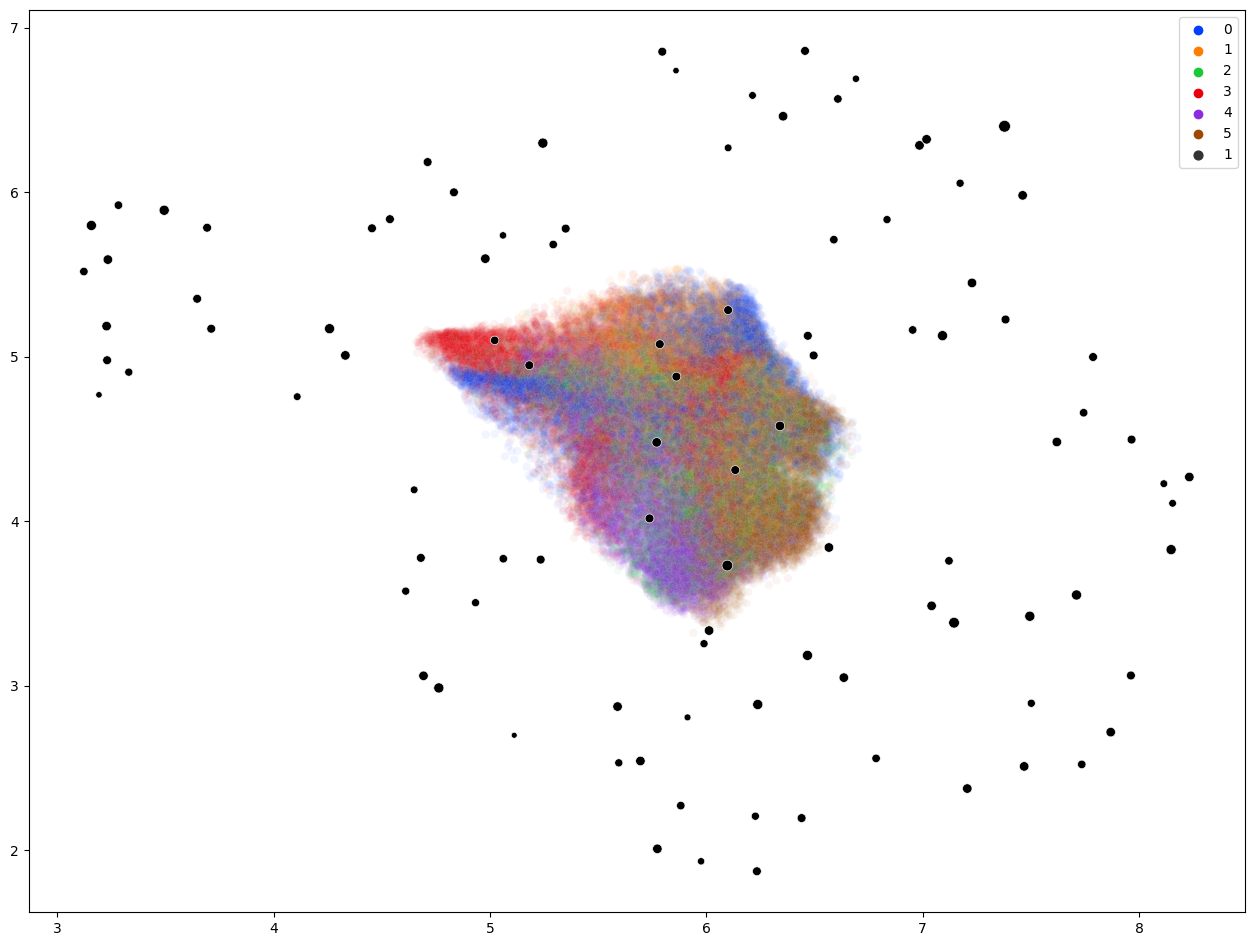

In [132]:

sns.scatterplot(
    x = graph_embs_test.T[0],
    y = graph_embs_test.T[1],
    alpha = 0.05,
    #hue = np.isin(y, 1 + np.array([0,1])),#np.random.choice(y, len(y)),
    hue = y_test,#np.random.choice(y, len(y)),
    #palette = "YlOrBr",
    palette = "bright",
)



sns.scatterplot(
    x = graph_net_embs.T[0],
    y = graph_net_embs.T[1],
    size = graph_importances.flatten(),
    color = "black"
)
plt.subplots_adjust(-1,-1)

In [134]:
cluster_net_embs = cluster_embedder[1].network_embeddings_
cluster_importances = cluster_embedder[1].archetype_importances_

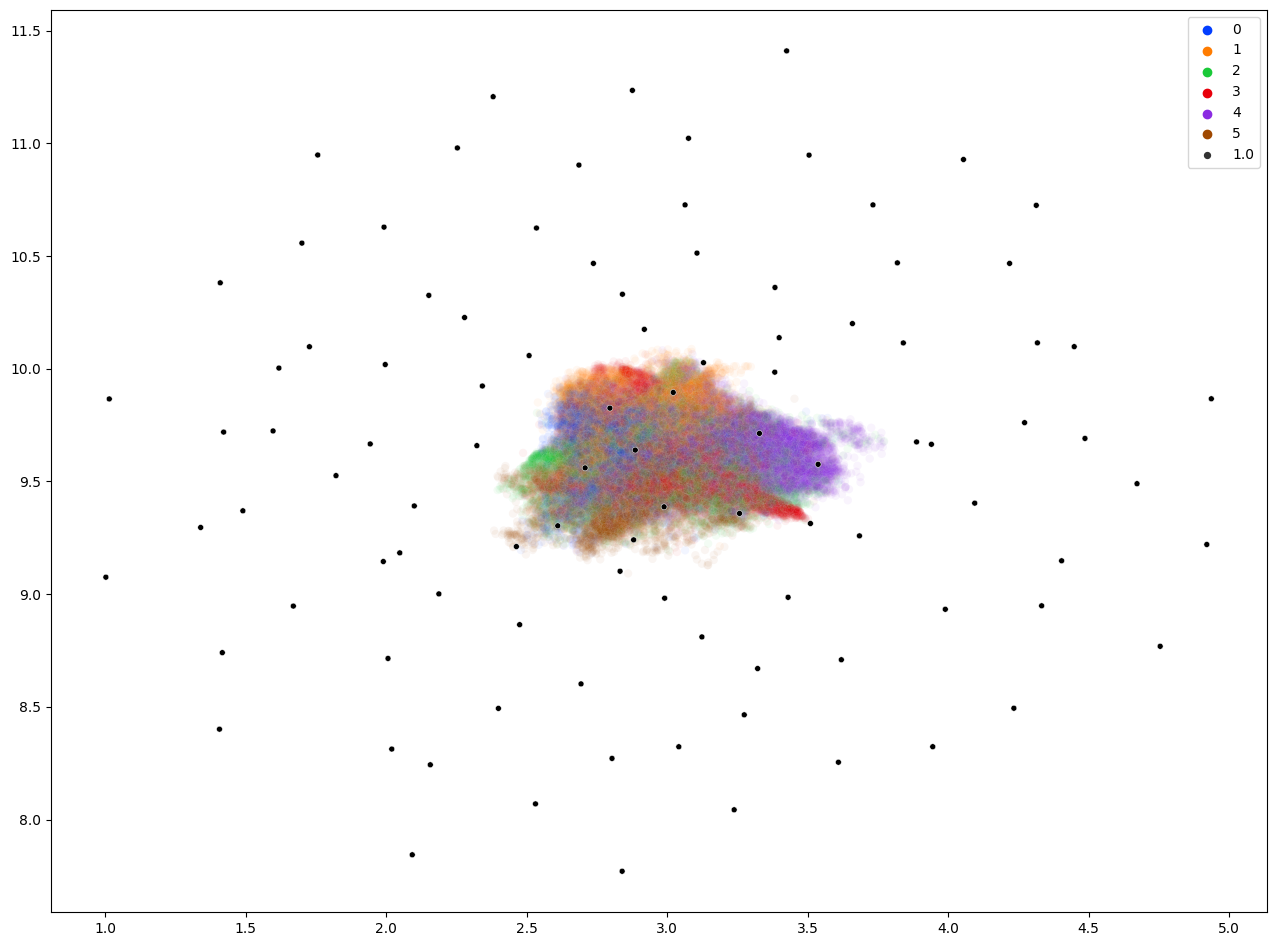

In [135]:

sns.scatterplot(
    x = cluster_embs_test.T[0],
    y = cluster_embs_test.T[1],
    alpha = 0.05,
    #hue = np.isin(y_test, 1 + np.array([0,1])),#np.random.choice(y, len(y)),
    hue = y_test,#np.random.choice(y, len(y)),
    #palette = "YlOrBr",
    palette = "bright",
)

sns.scatterplot(
    x = cluster_net_embs.T[0],
    y = cluster_net_embs.T[1],
    size = cluster_importances.flatten(),
    color = "black"
)
plt.subplots_adjust(-1,-1)

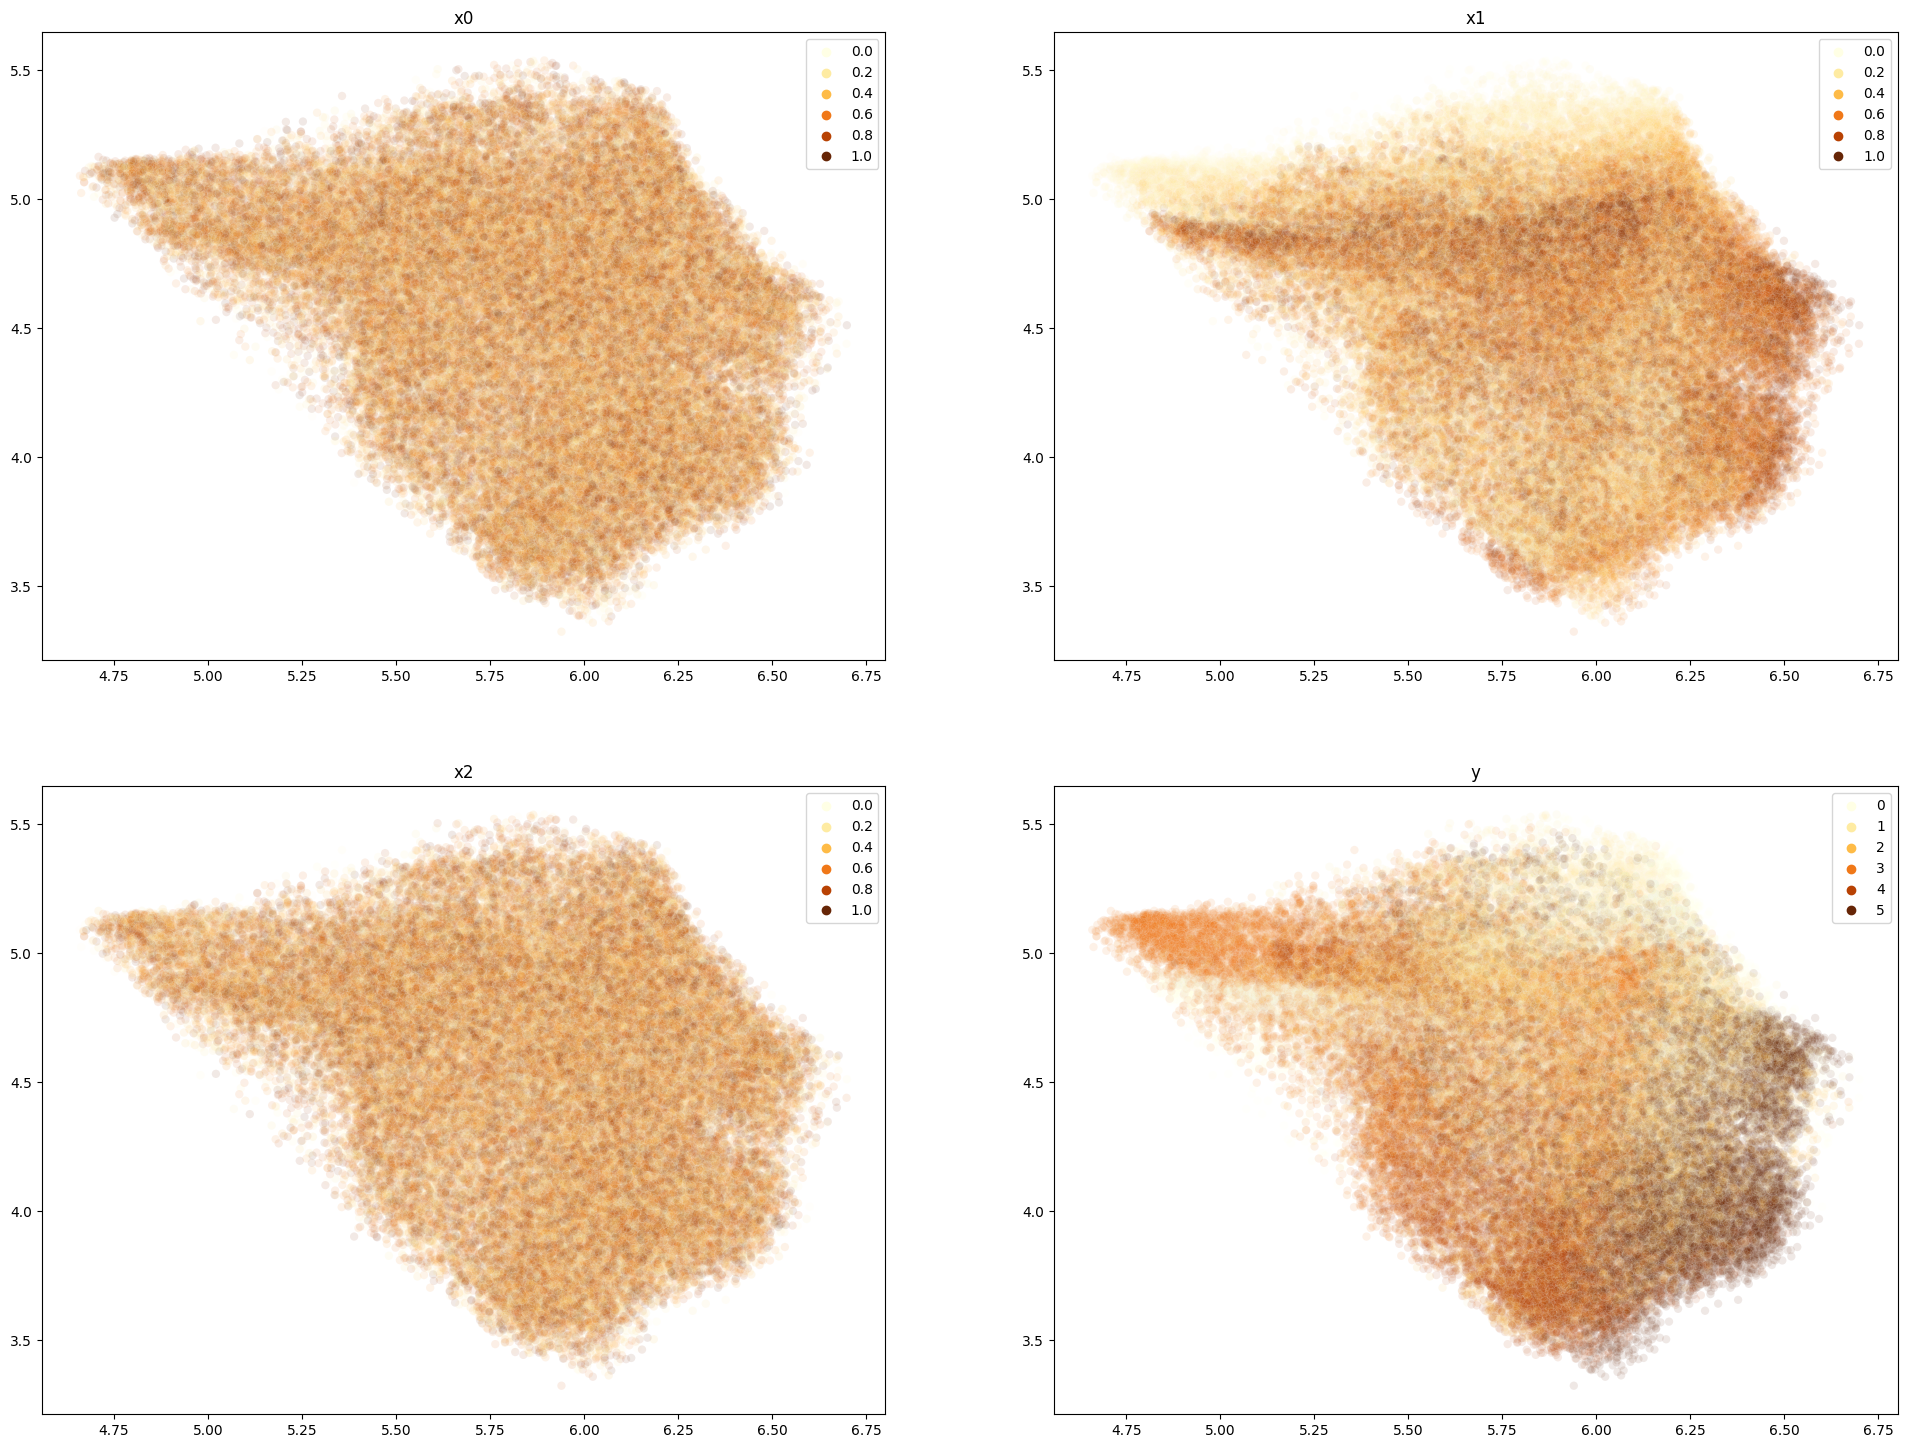

In [137]:
from sklearn.preprocessing import quantile_transform
fig,axs = plt.subplots(2,2)

sns.scatterplot(
    x = graph_embs_test.T[0],
    y = graph_embs_test.T[1],
    alpha = 0.1,
    hue = quantile_transform(X_test[:,0:1]).flatten(),
    palette = "YlOrBr",
    ax = axs[0,0],    
)
sns.scatterplot(
    x = graph_embs_test.T[0],
    y = graph_embs_test.T[1],
    alpha = 0.1,
    hue = quantile_transform(X_test[:,1:2]).flatten(),
    palette = "YlOrBr",
    ax = axs[0,1],
)

sns.scatterplot(
    x = graph_embs_test.T[0],
    y = graph_embs_test.T[1],
    alpha = 0.1,
    hue = quantile_transform(X_test[:,2:3]).flatten(),
    palette = "YlOrBr",
    ax = axs[1,0],
)

sns.scatterplot(
    x = graph_embs_test.T[0],
    y = graph_embs_test.T[1],
    alpha = 0.1,
    hue = y_test,
    palette = "YlOrBr",
    ax = axs[1,1],
)


axs[0,0].set_title ("x0")
axs[0,1].set_title ("x1")
axs[1,0].set_title ("x2")
axs[1,1].set_title ("y")
plt.subplots_adjust(-2,-2)
#sns.scatterplot(*embs.T)

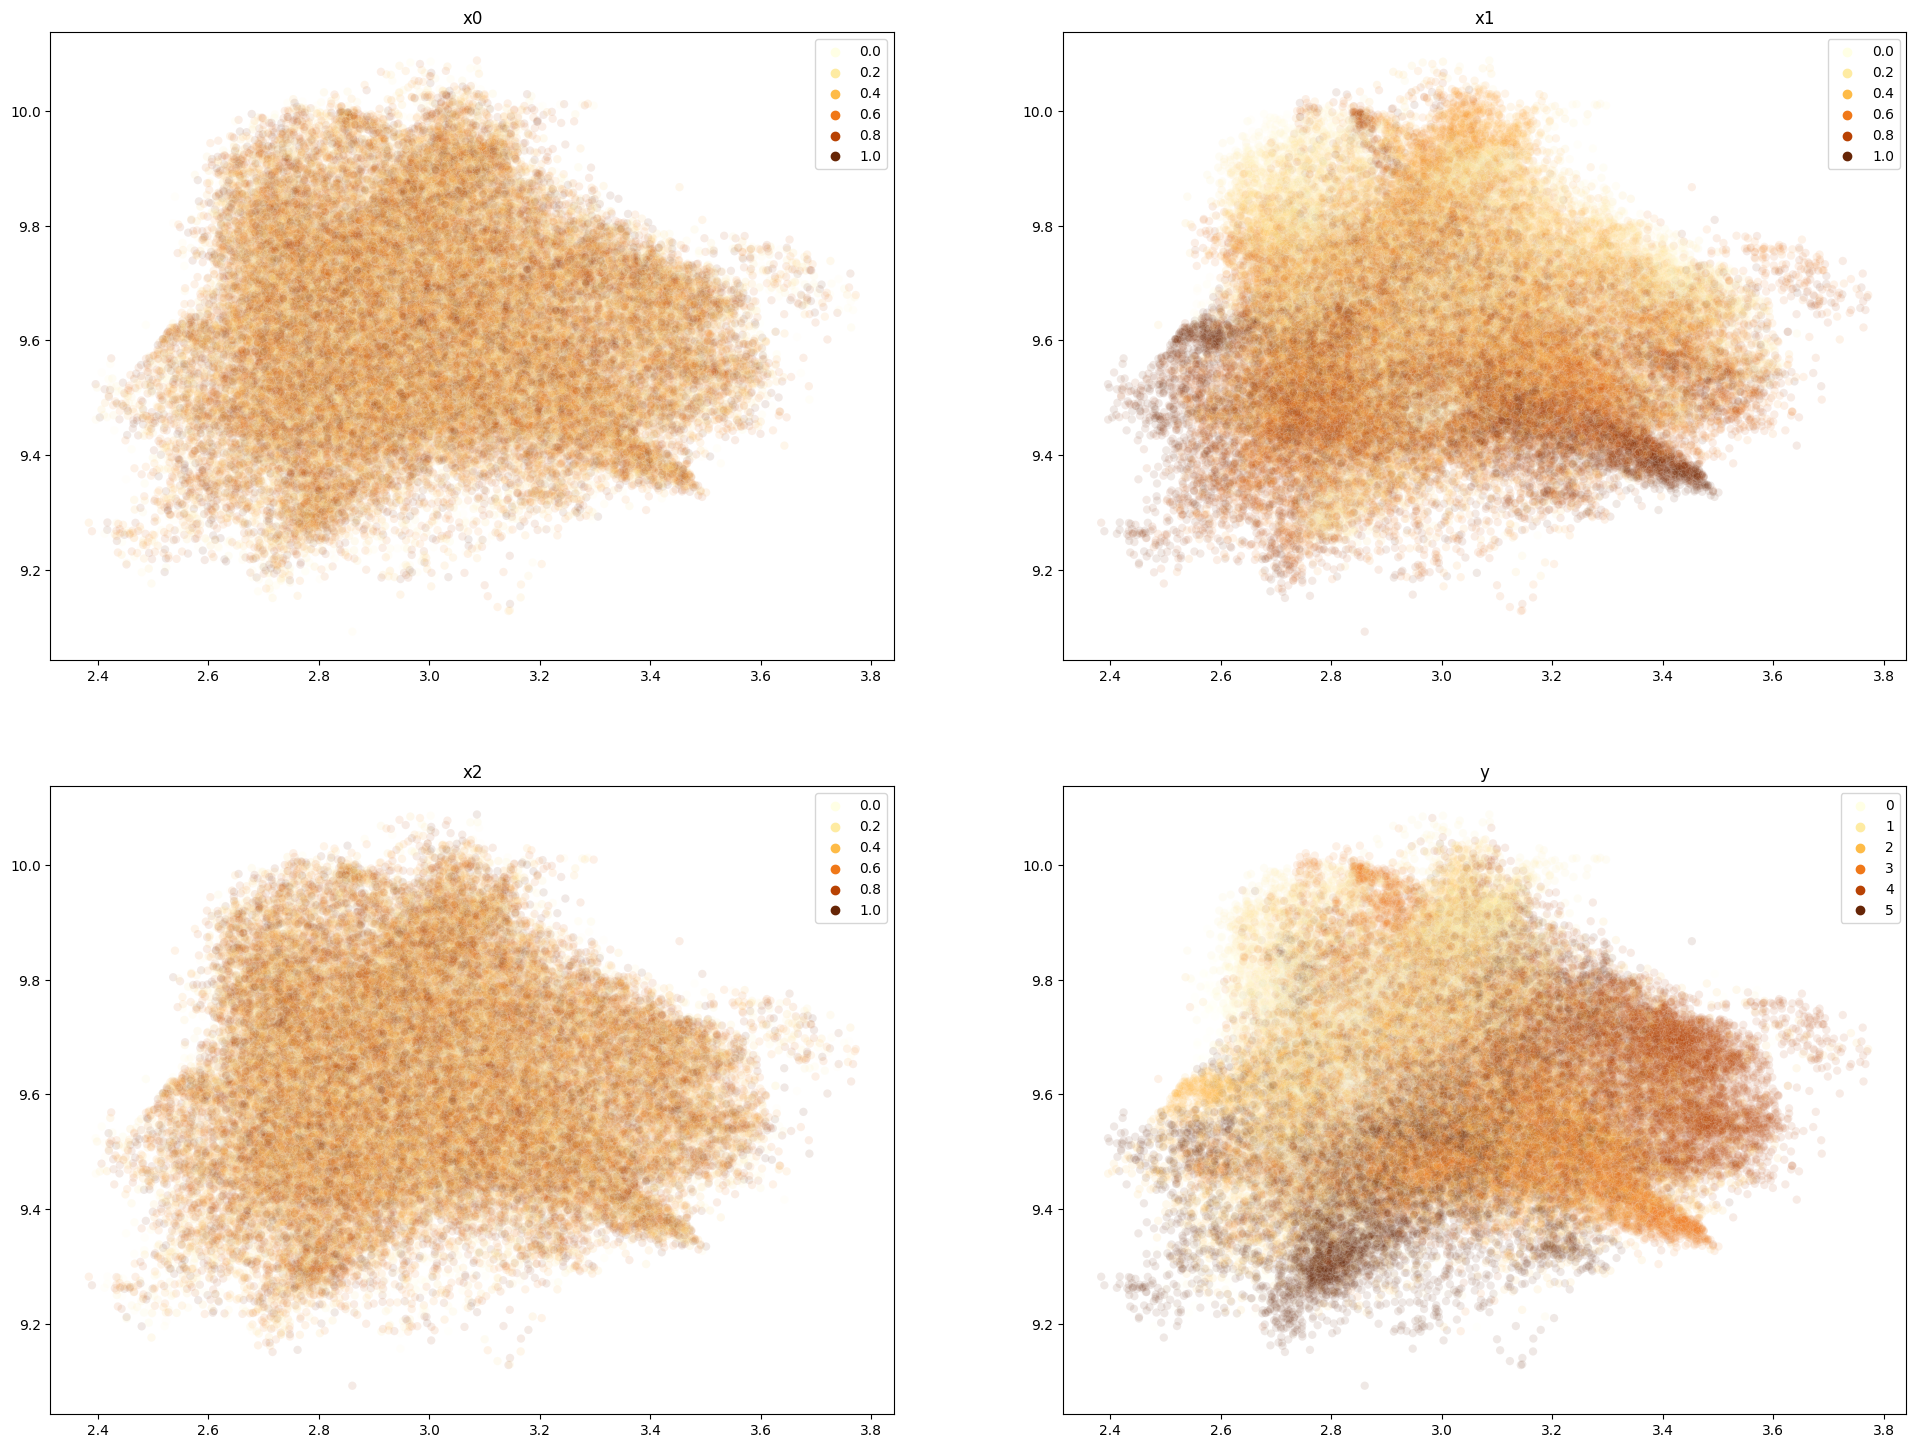

In [136]:
from sklearn.preprocessing import quantile_transform
fig,axs = plt.subplots(2,2)

sns.scatterplot(
    x = cluster_embs_test.T[0],
    y = cluster_embs_test.T[1],
    alpha = 0.1,
    hue = quantile_transform(X_test[:,0:1]).flatten(),
    palette = "YlOrBr",
    ax = axs[0,0],    
)
sns.scatterplot(
    x = cluster_embs_test.T[0],
    y = cluster_embs_test.T[1],
    alpha = 0.1,
    hue = quantile_transform(X_test[:,1:2]).flatten(),
    palette = "YlOrBr",
    ax = axs[0,1],
)

sns.scatterplot(
    x = cluster_embs_test.T[0],
    y = cluster_embs_test.T[1],
    alpha = 0.1,
    hue = quantile_transform(X_test[:,2:3]).flatten(),
    palette = "YlOrBr",
    ax = axs[1,0],
)

sns.scatterplot(
    x = cluster_embs_test.T[0],
    y = cluster_embs_test.T[1],
    alpha = 0.1,
    hue = y_test,
    palette = "YlOrBr",
    ax = axs[1,1],
)


axs[0,0].set_title ("x0")
axs[0,1].set_title ("x1")
axs[1,0].set_title ("x2")
axs[1,1].set_title ("y")
plt.subplots_adjust(-2,-2)
#sns.scatterplot(*embs.T)